In [1]:
#!pip install googletrans==4.0.0-rc1
#!pip install requests
#!pip install pandas
#!pip install matplotlib
#!pip install googletrans==4.0.0-rc1

In [2]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from googletrans import Translator

In [3]:
def search_companies_named(name, simple=False, save=False, df=True):

    '''

    Takes in a company name or part of it (string) and returns a dataframe with information about all companies named like that.

    Parameters:
    name (str): name of the company (or part of it) to search for. Not caps sensitive.
    simple (bool): False by default. If True, returns a simplified version of the dictionary with only the name, ehraid, and legalSeat of the company.
    save (bool): False by default. If True, saves the data to a JSON file called "name_companies.json". If simple is also True at the same time, saves the data to a JSON file called "name_companies_simple.json" instead.
    df (bool): True by default. If True, returns the data as a pandas DataFrame. If False, returns the data as a list of dictionaries.

    Returns:
    
    if df=False: 
    list_of_companies (list): a list of dictionaries, each containing information about a company found in the search

    if df=True (default): 
    list_of_companies (DataFrame): a pandas DataFrame containing information about all companies found in the search

    The dataframe in the list will contain the following information about the company:

    'name':                 <-- name of the company,
    'ehraid':               <-- unique identifier of the company,
    'legalSeat':            <-- location of the company's legal seat,
    'status':               <-- status of the company (active or not),
    'deleteDate':           <-- date when the company was deleted (if applicable),
    'wasTakenOverBy':       <-- name of the company that took over this one (if applicable),
    'purpose':              <-- purpose of the company,
    'legalForm':            <-- legal form of the company,
    'cancelled':            <-- boolean value indicating if the company is cancelled or not,
    'n_of_shabPub':         <-- number of publications in the Swiss Official Gazette of Commerce,
    'n_of_branchOffices':   <-- number of branch offices of the company,
    'n_of_oldNames':        <-- number of old names of the company,
    'n_of_hasTakenOver':    <-- number of companies taken over by this one,
    'town':                 <-- town where the company is located,
    'swissZipCode':         <-- Swiss zip code of the company,

    if simple=True, the dataframe/list of dictionaries will only contain the following:

    'name':                 <-- name of the company,
    'ehraid':               <-- unique identifier of the company,
    'legalSeat':            <-- location of the company's legal seat,

    '''
    # check if input is a string
    if type(name) != str:
        return "Please provide a string of the name of the company (or part of it) as input. Example: 'UBS' returns information about all companies with 'UBS' in their name."
    
    # access the information
    search_url = 'https://www.zefix.ch/ZefixREST/api/v1/firm/search.json'
    search_query = {
        "name" : name,
        "searchType" : "exact"
    }
    headers = {'Content-Type': 'application/json'}
    json_data = json.dumps(search_query)
    r = requests.post(search_url, headers=headers, data=json_data)

    # check if the request was successful, return error message if not
    if r.status_code == 400:
        return "400 Bad Request Error"
    elif r.status_code == 401:
        return "401 Unauthorized Error"
    elif r.status_code == 403:
        return "403 Forbidden Error"
    elif r.status_code == 404:
        return "404 Not Found Error"
    elif r.status_code == 408:
        return "408 Request Timeout Error"
    elif r.status_code == 500:
        return "500 Internal Server Error"
    elif r.status_code == 502:
        return "502 Bad Gateway Error"
    elif r.status_code == 504:
        return "504 Gateway Timeout Error"
    elif r.status_code != 200:
        return "Unexpected Error, the request was not successful"

    # convert response to json
    data = r.json()

    # create an empty list to store the information of the companies found in the search
    firm_data = []

    # populate the firm_data list with the information of the companies found in the search
    for i in range(len(data['list'])):
        firm_data.append(data['list'][i])

    # create an empty list to store the results for each of the companies found in the search
    list_of_companies = []

    # if option simple is true, return the simplified version of the dictionary
    if simple==True:
        for n in range(len(firm_data)):
            company = {}

            company['name'] = firm_data[n]['name']

            company['ehraid'] = firm_data[n]['ehraid']

            company['legalSeat'] = firm_data[n]['legalSeat']

            company['cantonalExcerptWeb'] = firm_data[n]['cantonalExcerptWeb']

            list_of_companies.append(company)

        # Save data to JSON file if option save is True
        if simple == True and save == True:
            with open(f'{name}_companies_simple.json', 'w') as file:
                json.dump(list_of_companies, file, indent=4)
            print(f"Data saved to {name}_companies_simple.json")
        
        # dataframe option
        if df==True:
            list_of_companies = pd.DataFrame(list_of_companies)
        
        return list_of_companies
    
    for n in range(len(firm_data)):

        # select ehraid
        ehraid = firm_data[n]['ehraid']

        # get information about the firm using its ehraid
        company_url = f"https://www.zefix.ch/ZefixREST/api/v1/firm/{ehraid}"
        r = requests.get(company_url)
        d = r.json()

        url = "https://www.zefix.ch/ZefixREST/api/v1/legalForm"
        response = requests.get(url)
        legal_forms = response.json()

        # create a dictionary with legal form id as key
        legal_forms_dictionary = {item['id']: item for item in legal_forms}

        # create empty dictionary to store the searched company information
        company={}
        
        # attributes to keep
        attributes = ['name', 'ehraid', 'legalSeat', 'cantonalExcerptWeb', 'status', 'deleteDate', 'wasTakenOverBy', 'purpose']

        # get request from zefix to get the desired company information
        company_url = f"https://www.zefix.ch/ZefixREST/api/v1/firm/{ehraid}"
        r = requests.get(company_url)
        data = r.json()
    
        for attrib in attributes:
            company[attrib] = data[attrib]
        
        #translate the information in 'purpuse' to english
        if company["purpose"]:
            translator = Translator()
            purpose_english = translator.translate(company['purpose'], dest='en')
            company['purpose'] = purpose_english.text

        #translate the information in 'status' to english
        if company["status"]:
            if company['status'].upper() == 'EXISTIEREND':
                company['status'] = 'Active'
            elif company['status'].upper() == 'GELOESCHT':
                company['status'] = 'Deleted'
            elif company['status'].upper() == 'IN_AUFLOESUNG':
                company['status'] = 'In Liquidation'
            else:
                translator = Translator()
                status_english = translator.translate(company['status'], dest='en')
                company['status'] = status_english.text

        # get the English name of a legal form associated with the given ID provided by the API
        firm_legal_form_name = legal_forms_dictionary[data['legalFormId']]['name']['en']

        # fill the legalForm field in the dictionary with the english name we just found
        company['legalForm'] = firm_legal_form_name 
        
        # cancelled field      
        if data['deleteDate'] is not None:
            company['cancelled'] = True
        else:
            company['cancelled'] = False
        
        # defining all the 'n_...' attributes by counting 
        len_fields = [ 'shabPub', 'branchOffices', 'oldNames', 'hasTakenOver']
        for field in len_fields:
            if data[field] is not None:
                company[f"n_of_{field}"] = len(data[field])
            else:
                company[f"n_of_{field}"] = 0
        
        # town/swissZipCode fields
        company['town'] = data['address']['town']
        company['swissZipCode'] = data['address']['swissZipCode']

        list_of_companies.append(company)

    # Save data to JSON file if option save is True
    if save == True:
        with open(f'{name}_companies.json', 'w') as file:
            json.dump(list_of_companies, file, indent=4)
        print(f"Data saved to {name}_companies.json")        

    # dataframe option
    if df==True:
        list_of_companies = pd.DataFrame(list_of_companies)

    return list_of_companies

example with both options true

In [4]:
search_companies_named('UBS', save=True)

Data saved to UBS_companies.json


,name,ehraid,legalSeat,cantonalExcerptWeb,status,deleteDate,wasTakenOverBy,purpose,legalForm,cancelled,n_of_shabPub,n_of_branchOffices,n_of_oldNames,n_of_hasTakenOver,town,swissZipCode
0,UBS AG,415520,Basel,https://bs.chregister.ch/cr-portal/auszug/ausz...,Active,None,None,The purpose of the company is the operation of...,Corporation,False,106,9,1,12,Basel,4051
1,UBS AG,421132,Zürich,https://zh.chregister.ch/cr-portal/auszug/ausz...,Active,None,None,The purpose of the company is the operation of...,Corporation,False,106,9,0,21,Zürich,8001
2,UBS Asset Management AG,1193524,Zürich,https://zh.chregister.ch/cr-portal/auszug/ausz...,Active,None,None,"The purpose of the company is the acquisition,...",Corporation,False,35,0,1,0,Zürich,8001
3,UBS Asset Management Switzerland AG,1372442,Zürich,https://zh.chregister.ch/cr-portal/auszug/ausz...,Active,None,None,The purpose of the company as a wealth manager...,Corporation,False,31,0,0,0,Zürich,8001
4,UBS Business Solutions AG,1236771,Zürich,https://zh.chregister.ch/cr-portal/auszug/ausz...,Active,None,None,The purpose of the company is the provision of...,Corporation,False,93,0,0,1,Zürich,8001
5,UBS Card Center AG,450214,Opfikon,https://zh.chregister.ch/cr-portal/auszug/ausz...,Active,None,None,The purpose of the company is the provision of...,Corporation,False,31,15,1,0,Glattbrugg,8152
6,UBS Clean Energy Infrastructure Switzerland 2 AG,1319041,Basel,https://bs.chregister.ch/cr-portal/auszug/ausz...,Active,None,None,The company works as a complementary for UBS C...,Corporation,False,6,0,0,0,Basel,4051
7,UBS Clean Energy Infrastructure Switzerland 2 ...,1321126,Basel,https://bs.chregister.ch/cr-portal/auszug/ausz...,Active,None,None,The exclusive purpose of society is the collec...,Limited Partnership for collective investment ...,False,9,0,0,0,Basel,4051
8,UBS Clean Energy Infrastructure Switzerland AG...,1121453,Basel,https://bs.chregister.ch/cr-portal/auszug/ausz...,In Liquidation,None,None,The company is a complementary for UBS Clean E...,Corporation,False,5,0,0,0,Basel,4051
9,"UBS Europe SE, Frankfurt am Main, Zweigniederl...",596115,Opfikon,https://zh.chregister.ch/cr-portal/auszug/ausz...,Active,None,None,Exercise of the banking business and all other...,Foreign branch,False,13,0,2,0,Opfikon,8152


In [5]:
search_companies_named('LALIVE', simple=True)

,name,ehraid,legalSeat,cantonalExcerptWeb
0,LALIVE SA,1219249,Genève,http://app2.ge.ch/ecohrcinternet/extract?lang=...


In [6]:
search_companies_named('MSC')

,name,ehraid,legalSeat,cantonalExcerptWeb,status,deleteDate,wasTakenOverBy,purpose,legalForm,cancelled,n_of_shabPub,n_of_branchOffices,n_of_oldNames,n_of_hasTakenOver,town,swissZipCode
0,MSC3S Marcel Schuppli Consulting Solutions Ser...,1328422,Hautemorges,https://prestations.vd.ch/pub/101266/extract?l...,Active,None,None,Project management and advice in the field of ...,Sole proprietorship,False,2,0,0,0,Apples,1143
1,MSC Air Cargo Holding SA,1613012,Genève,http://app2.ge.ch/ecohrcinternet/extract?lang=...,Active,None,None,"The subscription, the purchase, the sale, the ...",Corporation,False,2,0,0,0,Genève,1208
2,MSC Air Cargo SA,1557013,Genève,http://app2.ge.ch/ecohrcinternet/extract?lang=...,Active,None,None,"In Switzerland and abroad: acquisition, sale, ...",Corporation,False,4,0,0,0,Genève,1208
3,MSCA Transporte GmbH,1157460,Ostermundigen,https://be.chregister.ch/cr-portal/auszug/ausz...,Active,None,None,The company aims to operate a transport compan...,Limited Liability Company,False,3,0,2,0,Ostermundigen,3072
4,MSC Aviation SA,804250,Genève,http://app2.ge.ch/ecohrcinternet/extract?lang=...,Active,None,None,Exploitation of means of transport in particul...,Corporation,False,2,0,0,0,Genève,1208
5,MSC BOSS Gastro GmbH,1448317,Quarten,https://sg.chregister.ch/cr-portal/auszug/ausz...,Active,None,None,The company aims to lead catering drives and t...,Limited Liability Company,False,2,0,0,0,Flumserberg Tannenbodenalp,8898
6,MSC China GmbH,1611295,Cham,https://zg.chregister.ch/cr-portal/auszug/ausz...,Active,None,None,"The company aims to develop, implement and lic...",Limited Liability Company,False,1,0,0,0,Cham,6330
7,MSC Coaching GmbH,1490701,Egnach,https://tg.chregister.ch/cr-portal/auszug/ausz...,Active,None,None,"The company aims to offer advice, training and...",Limited Liability Company,False,2,0,0,0,Egnach,9322
8,"MSC Communication SA, en liquidation",666219,Genève,http://app2.ge.ch/ecohrcinternet/extract?lang=...,In Liquidation,None,None,"Business participation, import and export of s...",Corporation,False,1,0,2,0,Genève,1203
9,MSC Corporate Lugano SA,1551696,Lugano,https://ti.chregister.ch/cr-portal/auszug/ausz...,Active,None,None,"Wholesale and retail sale of pellets, timber a...",Corporation,False,1,0,0,0,Lugano,6900


In [7]:
search_companies_named('UBS', save=False, df=True)

,name,ehraid,legalSeat,cantonalExcerptWeb,status,deleteDate,wasTakenOverBy,purpose,legalForm,cancelled,n_of_shabPub,n_of_branchOffices,n_of_oldNames,n_of_hasTakenOver,town,swissZipCode
0,UBS AG,415520,Basel,https://bs.chregister.ch/cr-portal/auszug/ausz...,Active,None,None,The purpose of the company is the operation of...,Corporation,False,106,9,1,12,Basel,4051
1,UBS AG,421132,Zürich,https://zh.chregister.ch/cr-portal/auszug/ausz...,Active,None,None,The purpose of the company is the operation of...,Corporation,False,106,9,0,21,Zürich,8001
2,UBS Asset Management AG,1193524,Zürich,https://zh.chregister.ch/cr-portal/auszug/ausz...,Active,None,None,"The purpose of the company is the acquisition,...",Corporation,False,35,0,1,0,Zürich,8001
3,UBS Asset Management Switzerland AG,1372442,Zürich,https://zh.chregister.ch/cr-portal/auszug/ausz...,Active,None,None,The purpose of the company as a wealth manager...,Corporation,False,31,0,0,0,Zürich,8001
4,UBS Business Solutions AG,1236771,Zürich,https://zh.chregister.ch/cr-portal/auszug/ausz...,Active,None,None,The purpose of the company is the provision of...,Corporation,False,93,0,0,1,Zürich,8001
5,UBS Card Center AG,450214,Opfikon,https://zh.chregister.ch/cr-portal/auszug/ausz...,Active,None,None,The purpose of the company is the provision of...,Corporation,False,31,15,1,0,Glattbrugg,8152
6,UBS Clean Energy Infrastructure Switzerland 2 AG,1319041,Basel,https://bs.chregister.ch/cr-portal/auszug/ausz...,Active,None,None,The company works as a complementary for UBS C...,Corporation,False,6,0,0,0,Basel,4051
7,UBS Clean Energy Infrastructure Switzerland 2 ...,1321126,Basel,https://bs.chregister.ch/cr-portal/auszug/ausz...,Active,None,None,The exclusive purpose of society is the collec...,Limited Partnership for collective investment ...,False,9,0,0,0,Basel,4051
8,UBS Clean Energy Infrastructure Switzerland AG...,1121453,Basel,https://bs.chregister.ch/cr-portal/auszug/ausz...,In Liquidation,None,None,The company is a complementary for UBS Clean E...,Corporation,False,5,0,0,0,Basel,4051
9,"UBS Europe SE, Frankfurt am Main, Zweigniederl...",596115,Opfikon,https://zh.chregister.ch/cr-portal/auszug/ausz...,Active,None,None,Exercise of the banking business and all other...,Foreign branch,False,13,0,2,0,Opfikon,8152


In [8]:
def get_acquisitions_data(ehraid, hops=0, save=False, df=False):

    '''

    Takes in an ehraid (string) and returns a list of dictionaries with information about the firm and all the firms it has taken over. 
    This function finds both direct and indirect acquisitions. For example, if firm A has taken over firm B, and firm B has taken over firm C, 
    the function will return information about firm A, firm B, and firm C. Starting from A, the function will count the number of "hops" to reach
    the last firm in the chain. The function has an option to save the data to a JSON file.
    
    Parameters:
    ehraid (str): ehraid of the firm to start from
    hops (int): DO NOT CHANGE THIS VALUE, it is used as a counter for the number of hops from the initial ehraid
    save (bool): if True, saves the data to a JSON file called 'takeovers.json'
    df (bool): if True, returns the data as a pandas DataFrame

    Returns:

    if df=False (default):
    acquisitions (list): a list of dictionaries, each containing information about a firm and the firms it has taken over

    if df=True:
    acquisitions (DataFrame): a pandas DataFrame containing information about all firms and the firms they have taken over
    
    '''
    

    acquisitions = []

    # check if ehraid is a dictionary: if it is, get it as a string
    ehraid = ehraid.get('ehraid') if isinstance(ehraid, dict) else ehraid

    # get the data of the firm with the given ehraid from the API 
    url = f"https://www.zefix.ch/ZefixREST/api/v1/firm/{ehraid}"
    r = requests.get(url)
    data = r.json()

    # check if the request was successful, return error message if not
    if r.status_code == 400:
        return "400 Bad Request Error"
    elif r.status_code == 401:
        return "401 Unauthorized Error"
    elif r.status_code == 403:
        return "403 Forbidden Error"
    elif r.status_code == 404:
        return "404 Not Found Error"
    elif r.status_code == 408:
        return "408 Request Timeout Error"
    elif r.status_code == 500:
        return "500 Internal Server Error"
    elif r.status_code == 502:
        return "502 Bad Gateway Error"
    elif r.status_code == 504:
        return "504 Gateway Timeout Error"
    elif r.status_code != 200:
        return "Unexpected Error, the request was not successful"
    
    # Extract data of firm as a dictionary, with the number of hops from the initial ehraid
    firm = {
        "name": data.get("name"),
        "ehraid": data.get("ehraid"),
        "legalSeat": data.get("legalSeat"),
        "legalFormId": data.get("legalFormId"),
        "status": data.get("status"),
        "cantonalExcerptWeb": data.get("cantonalExcerptWeb"),
        "deleteDate": data.get("deleteDate"),
        "hops": hops
    }
    
    # translate the information in 'status' to english
    if firm["status"]:
        if firm['status'].upper() == 'EXISTIEREND':
            firm['status'] = 'Active'
        elif firm['status'].upper() == 'GELOESCHT':
            firm['status'] = 'Deleted'
        elif firm['status'].upper() == 'IN_AUFLOESUNG':
            firm['status'] = 'In Liquidation'
        else:
            translator = Translator()
            status_english = translator.translate(firm['status'], dest='en')
            firm['status'] = status_english.text
        
    acquisitions.append(firm)

    # if hastakenover is not empty, for each element in hastakenover run again this function with the element as input 
    # (since it's the ehrid of the firms taken over) and increase hops by 1
    
    if data["hasTakenOver"] is not None:
        for element in data["hasTakenOver"]:
            acquisitions.extend(get_acquisitions_data(element, hops + 1))

        
    # Save data to JSON file if user 
    if save == True:
        with open('takeovers.json', 'w') as file:
            json.dump(acquisitions, file, indent=4)
        print("Data saved to takeovers.json")

    if df==True:
        acquisitions = pd.DataFrame(acquisitions)

    return acquisitions

In [9]:
get_acquisitions_data('1578596')

[{'name': 'MSC Ventures AG',
  'ehraid': 1578596,
  'legalSeat': 'Bern',
  'legalFormId': 3,
  'status': 'Active',
  'cantonalExcerptWeb': 'https://be.chregister.ch/cr-portal/auszug/auszug.xhtml?uid=CHE-385.222.929',
  'deleteDate': None,
  'hops': 0}]

In [10]:
a = get_acquisitions_data('388851', save=False, df=False)
a

[{'name': 'Credit Suisse AG',
  'ehraid': 388851,
  'legalSeat': 'Zürich',
  'legalFormId': 3,
  'status': 'Active',
  'cantonalExcerptWeb': 'https://zh.chregister.ch/cr-portal/auszug/auszug.xhtml?uid=CHE-106.831.974',
  'deleteDate': None,
  'hops': 0},
 {'name': 'ABZ - Finanz- und Beteiligungsgesellschaft AG',
  'ehraid': 619,
  'legalSeat': 'Zug',
  'legalFormId': 3,
  'status': 'Deleted',
  'cantonalExcerptWeb': 'https://zg.chregister.ch/cr-portal/auszug/zefix.xhtml?uid=CHE-101.866.787&lang=de&shabdatum=20090706',
  'deleteDate': '2009-07-06',
  'hops': 1},
 {'name': 'Faminta AG',
  'ehraid': 55686,
  'legalSeat': 'Zürich',
  'legalFormId': 3,
  'status': 'Deleted',
  'cantonalExcerptWeb': 'https://zh.chregister.ch/cr-portal/auszug/zefix.xhtml?uid=CHE-102.833.750&lang=de&shabdatum=20080404',
  'deleteDate': '2008-04-04',
  'hops': 1},
 {'name': 'Hochhaus zur Palme AG',
  'ehraid': 81396,
  'legalSeat': 'Zürich',
  'legalFormId': 3,
  'status': 'Deleted',
  'cantonalExcerptWeb': 'ht

In [11]:
def plot_acquisitions(acquisitions):
    
    '''

    Takes in a list of dictionaries with information about firms and their acquisitions (output of the function acquisitions_data) and plots the acquisitions on a graph.
    From left to right, the x axis represents the number of acquisition "hops" from the initial firm. 
    
    Parameters:
    acquisitions (list of dictionaries): list of dictionaries with information about firms and their acquisitions. You can get data structured this way running the function acquisitions_data from the same package as this one.
    
    '''


    if type(acquisitions) != list:
        return "Please provide a list of dictionaries with information about firms and their acquisitions as input. You can get this data by running the function acquisitions_data in this same package. Use the default option df=False"
    
    if type(acquisitions[0]) != dict:
        return "Please provide a list of dictionaries with information about firms and their acquisitions as input. You can get this data by running the function acquisitions_data in this same package. Use the default option df=False"

    if 'hops' in acquisitions[0] and type(acquisitions[0]['hops']) == int:
        # create a dataframe with the acquisitions data
        df = pd.DataFrame(acquisitions)

        # add a colunm named y. For each different value of hops, assign to each record a value of y that goes from 0 upwards
        df['y'] = df.groupby('hops').cumcount()

        # add 0.2 to y to space the points from the x axis
        df['y'] = df['y'] + 0.2

        # create a plot
        plt.figure(figsize=(15, 10))

        # each point is a firm, with its name as label
        for i in range(len(df)):
            plt.text(df['hops'][i], df['y'][i], df['name'][i], ha='center', wrap=True)

        #the size of the plot depends on the number of hops (for width) and the number of y (for height)
        plt.xlim(0, df['hops'].max()+1)
        plt.ylim(0, df['y'].max()+1)

        #plot the points
        plt.scatter(df['hops'], df['y'], alpha=0)

        #add label of the x axis
        plt.xlabel('Number of Hops')

        #the x axis should have only integer values
        plt.xticks(range(df['hops'].max()+1))

        #add title
        plt.title('Acquisitions')

        #hide the y axis ticks
        plt.yticks([])

        #hide the borders
        plt.box(False)

        #show the plot
        plt.show()
    else:
        return "Please provide a list of dictionaries with information about firms and their acquisitions as input. You can get this data by running the function acquisitions_data in this same package. Use the default option df=False"
    


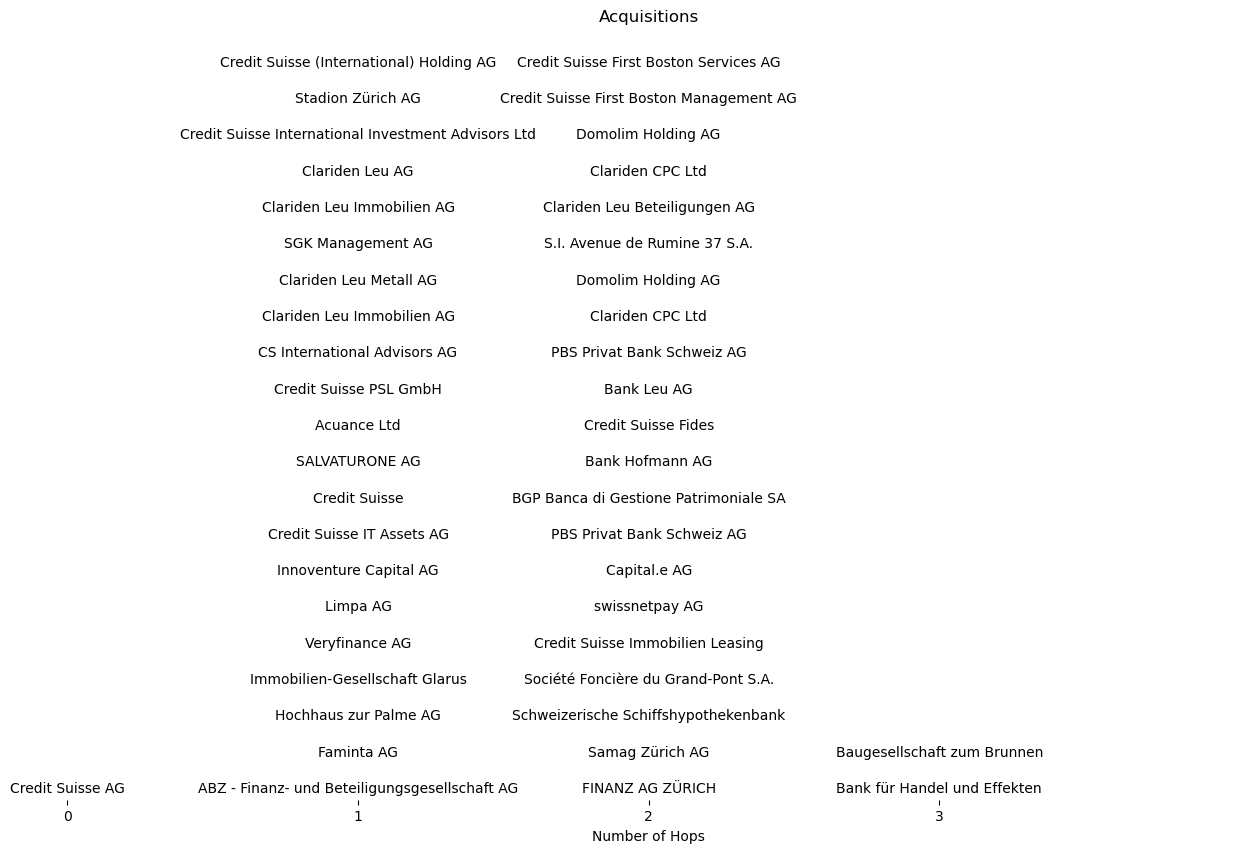

In [12]:
plot_acquisitions(a)

In [13]:
#This function checks a specific company (identified by its EHRAID) acquirers.
def check_acquirers(ehraid, df=True):
    
    '''
    
    This function takes in the EHRAID of a company and returns a list of dictionaries with information about the companies that took over the given company.

    Parameters:
    ehraid (str): EHRAID of the company to check the acquirers for.
    df (bool): True by default. If True, returns the data as a pandas DataFrame. If False, returns the data as a list of dictionaries.

    Returns:
    if df=True (default):
    acquirers (dataframe): a dataframe with information about the companies that took over the given company. If df=False, returns a list of dictionaries.

    if df=False:
    acquirers (list): a list of dictionaries with information about the companies that took over the given company.

    '''

    if type(ehraid) != str:
        return "Please provide a string of the EHRAID of the company as input. Example: '110662'"

    company_url = f'https://www.zefix.ch/ZefixREST/api/v1/firm/{ehraid}'
    r = requests.get(company_url)
    data = r.json()

    if r.status_code != 200:
        print(f"Failed to fetch details for EHRAID {ehraid}:", r.text)
        return None
    
    was_taken_over_by = data.get('wasTakenOverBy', [])
    if not was_taken_over_by:
        print(f"No acquisition records found for EHRAID {ehraid}.")
        return None
    
    # get the legal form names from the API
    legal_form_url = "https://www.zefix.ch/ZefixREST/api/v1/legalForm"
    legal_forms_response = requests.get(legal_form_url)
    legal_forms = legal_forms_response.json()

    if legal_forms_response.status_code != 200:
        print("Failed to fetch details for legal forms. The legal form will be provided as a numeric id. Read the zefix documentation for further details on what that id means.")
    
    
    # search the details for the acquirer company and save them
    acquirers = []
    for acquirer in was_taken_over_by:
        acquirer_details = requests.get(f'https://www.zefix.ch/ZefixREST/api/v1/firm/{acquirer["ehraid"]}')
        acquirer_data = acquirer_details.json()
        
        if acquirer_details.status_code != 200:
            print(f"Failed to fetch details for acquirer EHRAID {acquirer['ehraid']}:", acquirer_details.text)
            continue

        # Here we specify the information we are looking for

        # create a dictionary with legal form id as key
        legal_forms_dictionary = {item['id']: item for item in legal_forms}

        # get the English name of a legal form associated with the given ID provided by the API
        firm_legal_form_name = legal_forms_dictionary[data['legalFormId']]['name']['en']

        record = {
            'name': acquirer_data['name'],
            'ehraid': acquirer_data['ehraid'],
            'legalSeat': acquirer_data.get('legalSeat'),
            "legalFormId": acquirer_data.get("legalFormId") if legal_forms_response.status_code != 200 else firm_legal_form_name ,
            'status': acquirer_data.get('status'),
            "cantonalExcerptWeb": acquirer_data.get("cantonalExcerptWeb"),
            'deleteDate': acquirer_data.get('deleteDate'),
            'purpose':acquirer_data.get('purpose'),
            'capitalNominal':acquirer_data.get('capitalNominal'),
            }
        
        #translate the information in 'purpuse' to english
        if record["purpose"]: 
            translator = Translator()
            purpose_english = translator.translate(record['purpose'], dest='en')
            record['purpose'] = purpose_english.text

        #translate the information in 'status' to english
        if record["status"]:    
            if record['status'].upper() == 'EXISTIEREND':
                record['status'] = 'Active'
            elif record['status'].upper() == 'GELOESCHT':
                record['status'] = 'Deleted'
            elif record['status'].upper() == 'IN_AUFLOESUNG':
                record['status'] = 'In Liquidation'
            else:
                translator = Translator()
                status_english = translator.translate(record['status'], dest='en')
                record['status'] = status_english.text

        acquirers.append(record)
         
    if df==True:
        acquirers = pd.DataFrame(acquirers)

    return acquirers

# Exemple of EHRAID(UBS)
ehraid = "110662"
acquired_details_df = check_acquirers(ehraid, df=True)

acquired_details_df

,name,ehraid,legalSeat,legalFormId,status,cantonalExcerptWeb,deleteDate,purpose,capitalNominal
0,UBS AG,415520,Basel,Corporation,Active,https://bs.chregister.ch/cr-portal/auszug/ausz...,None,The purpose of the company is the operation of...,None
1,UBS AG,421132,Zürich,Corporation,Active,https://zh.chregister.ch/cr-portal/auszug/ausz...,None,The purpose of the company is the operation of...,None


In [14]:
get_acquisitions_data('421132', df=True)

,name,ehraid,legalSeat,legalFormId,status,cantonalExcerptWeb,deleteDate,hops
0,UBS AG,421132,Zürich,3,Active,https://zh.chregister.ch/cr-portal/auszug/ausz...,None,0
1,SBC Wealth Management AG,699716,Zug,3,Deleted,https://zg.chregister.ch/cr-portal/auszug/zefi...,2005-11-16,1
2,Cantrade Beteiligungs AG,30514,Zürich,3,Deleted,https://zh.chregister.ch/cr-portal/auszug/zefi...,2002-04-16,1
3,UBS Factoring AG,55250,Zürich,3,Deleted,https://zh.chregister.ch/cr-portal/auszug/zefi...,2009-11-18,1
4,Indelec Holding AG,88691,Basel,3,Deleted,https://bs.chregister.ch/cr-portal/auszug/zefi...,2004-03-01,1
5,Luxor-Aktiengesellschaft Zürich,110662,Zürich,3,Deleted,https://zh.chregister.ch/cr-portal/auszug/zefi...,2009-05-28,1
6,Ransila AG,143255,Zug,3,Deleted,https://zg.chregister.ch/cr-portal/auszug/zefi...,2006-06-16,1
7,RENTA Aktiengesellschaft für Finanzplanung,145610,Zürich,3,Deleted,https://zh.chregister.ch/cr-portal/auszug/zefi...,2006-06-16,1
8,Zur Schanzenbrücke AG,161509,Zürich,3,Deleted,https://zh.chregister.ch/cr-portal/auszug/zefi...,2006-12-14,1
9,Schweizerische Gesellschaft für Anlagewerte,165965,Basel,3,Deleted,https://bs.chregister.ch/cr-portal/auszug/zefi...,2008-07-08,1
